# Advection

In [9]:
import numpy as np
import pystencils as ps
import sympy as sp
from pystencils import plot as plt

In [10]:
domain_size = (200, 80)
dim = len(domain_size)

# create arrays
c_arr = np.zeros(domain_size)
v_arr = np.zeros(domain_size + (dim,))

# create fields
c, v, c_next = ps.fields("c, v(2), c_next: [2d]", c=c_arr, v=v_arr, c_next=c_arr)

# write down advection diffusion pde
# the equation is represented by a single term and an implicit "=0" is assumed.
adv_diff_pde = (
    ps.fd.transient(c) - ps.fd.diffusion(c, sp.Symbol("D")) + ps.fd.advection(c, v)
)
adv_diff_pde

Advection(c_C, v_C^0) - Diffusion(c_C, D) + Transient(c_C)

In [11]:
discretize = ps.fd.Discretization2ndOrder(1, 0.01)
discretization = discretize(adv_diff_pde)
discretization.subs(sp.Symbol("D"), 1)

0.96*c_C - 0.005*c_E*v_E^0 + 0.01*c_E - 0.005*c_N*v_N^1 + 0.01*c_N + 0.005*c_S*v_S^1 + 0.01*c_S + 0.005*c_W*v_W^0 + 0.01*c_W

In [12]:
ast = ps.create_kernel(
    [ps.Assignment(c_next.center(), discretization.subs(sp.Symbol("D"), 1))]
)
kernel = ast.compile()

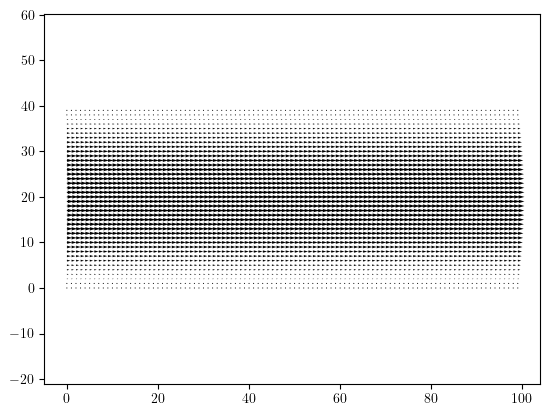

In [13]:
y = np.linspace(0, 1, v_arr.shape[1])
v_arr[:, :, 0] = -y * (y - 1.0) * 5
plt.vector_field(v_arr);

In [14]:
def boundary_handling(c):
    # No concentration at the upper, lower wall and the left inflow border
    c[:, 0] = 0
    c[:, -1] = 0
    c[0, :] = 0
    # At outflow border: neumann boundaries by copying last valid layer
    c[-1, :] = c[-2, :]

    # Some source inside the domain
    c[10:15, 25:30] = 1.0
    c[20:25, 60:65] = 1.0


c_tmp_arr = np.empty_like(c_arr)


def timeloop(steps=100):
    global c_arr, c_tmp_arr
    for i in range(steps):
        boundary_handling(c_arr)
        kernel(c=c_arr, c_next=c_tmp_arr, v=v_arr)
        c_arr, c_tmp_arr = c_tmp_arr, c_arr
    return c_arr

AttributeError: module 'pystencils' has no attribute 'jupyter'

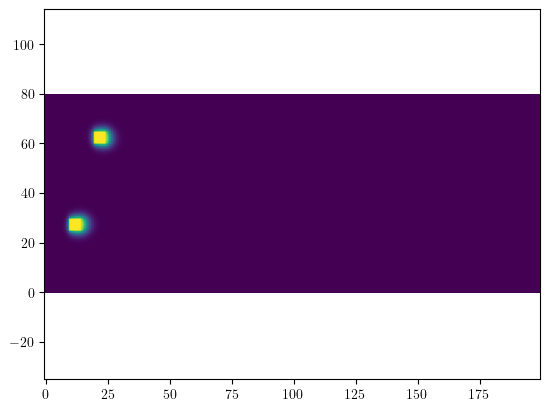

In [15]:
# if 'is_test_run' in globals():
#     timeloop(10)
#     result = None
# else:
#     ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=300)
#     result = ps.jupyter.display_as_html_video(ani)
# result